In [ ]:
import os 
import sys
import math

import pickle
import optuna
import logging
import numpy as np
import pandas as pd
import seaborn as sn
# from tqdm import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

%matplotlib inline

np.random.seed(2022)
data_folder = '../data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

In [ ]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1', 'nbr1_LU3', 'nbr1_LC3', 'nbr1_LU2', 'nbr1_LC2', 'nbr1_LU1',
           'nbr1_LC1', 'nbr2_LU3', 'nbr2_LC3', 'nbr2_LU2', 'nbr2_LC2', 'nbr2_LU1', 'nbr2_LC1', 'nbr3_LU3', 'nbr3_LC3',
           'nbr3_LU2', 'nbr3_LC2', 'nbr3_LU1', 'nbr3_LC1', 'nbr4_LU3', 'nbr4_LC3', 'nbr4_LU2', 'nbr4_LC2', 'nbr4_LU1',
           'nbr4_LC1', 'nbr5_LU3', 'nbr5_LC3', 'nbr5_LU2', 'nbr5_LC2', 'nbr5_LU1', 'nbr5_LC1', 'nbr6_LU3', 'nbr6_LC3',
           'nbr6_LU2', 'nbr6_LC2', 'nbr6_LU1', 'nbr6_LC1', 'nbr7_LU3', 'nbr7_LC3', 'nbr7_LU2', 'nbr7_LC2', 'nbr7_LU1',
           'nbr7_LC1', 'nbr8_LU3', 'nbr8_LC3', 'nbr8_LU2', 'nbr8_LC2', 'nbr8_LU1', 'nbr8_LC1']

original_data = pd.read_csv(os.path.join(data_folder, 'trainset_with_neighbour.csv'), index_col=0)
original_data = original_data[columns]
original_data.head()

In [ ]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

In [ ]:
data_features = original_data.copy()
data_features['changed'] = [0 if row['LU4'] == row['LU3'] and row['LC4'] == row['LC3'] else 1 for ind, row in data_features[['LU4', 'LC4', 'LU3', 'LC3']].iterrows()]
data_features.drop(['LC4', 'LU4'], axis=1, inplace=True)
data_features.head()

In [ ]:
print('Total number of tiles that changed label in either Land Cover or Land Usage: %d' % sum(data_features.changed))

In [ ]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [ ]:
[train, test] = split_set(data_features)

In [ ]:
train_categorical = pd.get_dummies(train)
train_categorical.columns

In [ ]:
# Make sure we use only the features available in the training set
test_categorical = pd.get_dummies(test)[train_categorical.columns]

In [10]:
train_label=train_categorical.changed
train_features = train_categorical.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test_categorical.changed
test_features = test_categorical.drop('changed', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 278198
Length of the test dataset : 70276


### B) Train a random forest classifier on your training set. 

# XGboost & Random Forest 

In [16]:
class Classsifers():
    
    def __init__(self, train_x, train_y, classifers, study_name, n_trials=20):
        '''
        init the finetuning of multiple classifiers
        @params:
        train_x: input training features
        train_y: ground-truth label of training set
        ...
        classifiers: name of classifier to optimize
        '''
        self.train_x = train_x
        self.train_y = train_y
        self._classsifers = classifers
        self.n_cpus = int(os.cpu_count() / 2)
        self.n_trials = n_trials
        self.study_name = study_name
        self.storage_name = "sqlite:///{}.db".format(study_name)
        self.acc_mean = 0
        self.study = optuna.create_study(study_name=self.study_name, direction='maximize', storage=self.storage_name, load_if_exists=True)
        try:
            # if os.path.exists('./{}.db'.format(study_name)):
            self.best_opt_metric = self.study.best_value
            self._best_params = self.study.best_params
        except ValueError:
            pass
            
        
    def objective(self, trial):
        # define the tuning object with fields and range of the hyper params
        classsifer = trial.suggest_categorical('classsifer', self._classsifers)

        if classsifer == 'RandomForest':
            # cf. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

            params = dict(
                criterion = "gini",
                bootstrap = True,
                max_depth = 500,
                max_features = trial.suggest_categorical('max_features', [None, 'sqrt','log2']),
                min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
                min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10),
                n_estimators =  500,
                class_weight = 'balanced_subsample',
                n_jobs=self.n_cpus
            )
            model = RandomForestClassifier(**params)

        elif classsifer == 'XGBoost':
            # cf. https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=n_estimators#module-xgboost.sklearn
            params = dict(
                booster = trial.suggest_categorical('booster', ["gbtree"]),
                learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3),
                gamma = trial.suggest_float('gamma', 0, 1),
                max_depth = trial.suggest_int('max_depth', 3, 15),
                n_estimators = int(trial.suggest_float('n_estimators', 1000, 4000, step=500)),
                min_child_weight = trial.suggest_int('min_child_weight', 1, 12),
                gpu_id = 0,
                tree_method = 'gpu_hist'
            )
            model = XGBClassifier(**params, n_jobs=self.n_cpus, importance_type='gain')

        elif classsifer == 'LightGBM':
            # cf. https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
            params = dict(  
                learning_rate = trial.suggest_float('learning_rate', 0.01, 0.02),
                num_leaves = trial.suggest_int('num_leaves', 2, 50),
                max_depth = trial.suggest_int('max_depth', 1, 50),
                n_estimators = int(trial.suggest_float('n_estimators', 100, 1000, step=100)),
                min_child_samples = trial.suggest_int('min_child_samples', 1, 10)
            )
            model = LGBMClassifier(**params, n_jobs=self.n_cpus, importance_type='gain')
            # model = LGBMClassifier(**params, n_jobs=self.n_cpus, importance_type='gain', device = 'gpu',
            #                        gpu_platform_id = 0, gpu_device_id = 0)

        else:
            raise Exception('Invalid regressor. Only the following choices are valid: "RandomForest", "XGBoost", "LightGBM".')

        score = cross_val_score(model, self.train_x, self.train_y, cv=5, scoring="balanced_accuracy")
        acc_mean = score.mean()

        return acc_mean
        
    def optimize(self, cv=5):
        # hyper params tuning with Optuna
        # detailed explanation of Optuna: https://optuna.org/

        self.study.optimize(self.objective, n_trials=self.n_trials, n_jobs=max(self.n_cpus, 1))

        # /!\ we need to make sure that type(n_estimators) == 'int'
        best_params = self.study.best_params.copy()
        best_params['n_estimators'] = int(best_params['n_estimators'])
        print("Best parameters:", best_params)
        print("Best score (mean balanced_accuracy after 5-fold Cross Validation):", self.study.best_value)
        self._best_params = best_params
        self.best_opt_metric = self.study.best_value

        
    def compute_confusion_matrix(self): 
    
        TP = np.sum(np.logical_and(self._predict_label_test==1, self._true_label_test==1))
        TN = np.sum(np.logical_and(self._predict_label_test==0, self._true_label_test==0))
        FP = np.sum(np.logical_and(self._predict_label_test==1, self._true_label_test==0))
        FN = np.sum(np.logical_and(self._predict_label_test==0, self._true_label_test==1))

        self._confusion_matrix = np.asarray([[TP, FP],
                                        [FN, TN]])
        return self._confusion_matrix


    def plot_confusion_matrix(self):
        [[TP, FP],[FN, TN]] = self._confusion_matrix
        label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                            ['FN {}'.format(FN), 'TN {}'.format(TN)]])

        df_cm = pd.DataFrame(self._confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 

        sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Confusion matrix')



    def compute_score(self):
        [[TP, FP],[FN, TN]] = self._confusion_matrix.astype(float)

        accuracy =  (TP+TN)/np.sum(self._confusion_matrix)

        precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
        precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan

        recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
        recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

        F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
        F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

        print("The accuracy of model is {:1.3f}".format(accuracy))
        print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
              .format(precision_positive, recall_positive, F1_score_positive))
        print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
              .format(precision_negative, recall_negative, F1_score_negative))

        return {
            'accuracy': accuracy,
            'precision_positive': precision_positive,
            'recall_positive': recall_positive,
            'F1_score_positive': F1_score_positive,
            'precision_negative': precision_negative,
            'recall_negative': recall_negative,
            'F1_score_negative': F1_score_negative
        }

        
        
    def best_model(self):
        # init the best model with optimized params
        params_dict = self._best_params.copy()
        cls_best = params_dict.pop('classsifer')
        if cls_best == 'RandomForest':
            params_dict['n_estimators'] = 500
            best_model = RandomForestClassifier(**params_dict, n_jobs=self.n_cpus)
        elif cls_best == 'XGBoost':
            params_dict['n_estimators'] = int(params_dict['n_estimators'])
            best_model = XGBClassifier(**params_dict, n_jobs=self.n_cpus, gpu_id = 0, tree_method = 'gpu_hist',
                                       importance_type='gain')
        elif cls_best == 'LightGBM':
            params_dict['n_estimators'] = int(params_dict['n_estimators'])
            best_model = LGBMClassifier(**params_dict, n_jobs=self.n_cpus, importance_type='gain')
            # best_model = LGBMClassifier(**params_dict, n_jobs=self.n_cpus, importance_type='gain', device = 'gpu')
            # gpu_platform_id = 0, gpu_device_id = 0
        print(params_dict)
                
        best_model.fit(self.train_x, self.train_y)
        score = cross_val_score(best_model, self.train_x, self.train_y, cv=5, scoring="balanced_accuracy")
        self.score = score.mean()
        self.best_model = best_model
        
        print('Best model initialized with balanced accuracy: {:.3f} \n'.format(self.score))

    
    def _evaluate(self, test_x, test_y):
        # evaluate the performance of given test data
        self._true_label_test = test_y
        from sklearn.metrics import balanced_accuracy_score
        self._predict_label_test = self.best_model.predict(test_x)
        acc_balanced = balanced_accuracy_score(self._true_label_test, self._predict_label_test)
        
    
    def save_model(self, path):
        # Save to file in the current working directory
        with open(path, 'wb') as file:
            pickle.dump(self.best_model, file)
        
    
    def load_model(self, path):
        # Load from file
        with open(path, 'rb') as file:
            self.best_model = pickle.load(file)
        

## Train and test the models

In [17]:
test_cls = Classsifers(train_x=train_features, train_y=train_label, classifers=['RandomForest'], study_name='RandomForest', n_trials=200)

[I 2022-09-26 01:43:57,709] Using an existing study with name 'RandomForest' instead of creating a new one.


In [ ]:
test_cls.optimize()

In [18]:
test_cls.best_opt_metric

0.7154270346556824

In [19]:
test_cls._best_params

{'classsifer': 'RandomForest',
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [20]:
test_cls.best_model()

{'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 500}
Best model initialized with balanced accuracy: 0.557 



In [65]:
test_cls.load_model('./xgboost_615.pkl')

In [21]:
test_cls.save_model('./RandomForest_715.pkl')

In [66]:
test_cls._evaluate(test_features, test_label)

In [67]:
test_cls.compute_confusion_matrix()

array([[ 3523,  3089],
       [ 8338, 55326]])

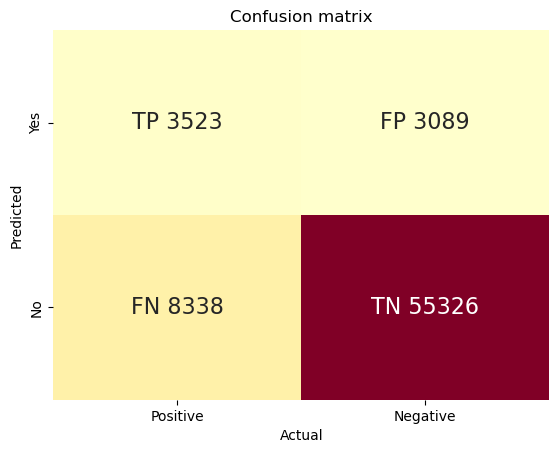

In [68]:
test_cls.plot_confusion_matrix()

In [69]:
test_cls.compute_score()

The accuracy of model is 0.837
For the positive case, the precision is 0.533, the recall is 0.297 and the F1 score is 0.381
For the negative case, the precision is 0.869, the recall is 0.947 and the F1 score is 0.906


{'accuracy': 0.837398258295862,
 'precision_positive': 0.5328191167574108,
 'recall_positive': 0.29702385970828765,
 'F1_score_positive': 0.3814215341308937,
 'precision_negative': 0.8690311636089469,
 'recall_negative': 0.9471197466404176,
 'F1_score_negative': 0.9063966775612512}

## Feature importance analysis

In [70]:
feature_imp = pd.DataFrame([[f, imp] for f, imp in zip(train_features.columns, test_cls.best_model.feature_importances_)], columns=['feature', 'feature_importance'])
feature_imp.sort_values('feature_importance', inplace=True, ascending=False)
feature_imp = feature_imp.query('feature_importance > 0')
feature_imp.head()

,feature,feature_importance
45,LU3_LU424,0.038479
18,LU3_LU146,0.035272
205,LC1_LC41,0.021908
32,LU3_LU241,0.013637
142,LC2_LC61,0.011132


In [71]:
feature_imp.head(10)

,feature,feature_importance
45,LU3_LU424,0.038479
18,LU3_LU146,0.035272
205,LC1_LC41,0.021908
32,LU3_LU241,0.013637
142,LC2_LC61,0.011132
34,LU3_LU243,0.009491
37,LU3_LU303,0.009324
57,LC3_LC34,0.008040
47,LC3_LC12,0.005886
71,LC3_LC63,0.005875


In [72]:
super_f = []
time_space = []
for ind, f in feature_imp.iterrows():
    super_f.append('_'.join(f['feature'].split('_')[:-1]))
    if f['feature'].startswith('nbr'):
        time_space.append('neighour')
    else:
        time_space.append('self')

feature_imp['super_feat'] = super_f
feature_imp['time_space'] = time_space

In [73]:
df_ts = feature_imp.groupby(['time_space']).sum()
df_ts.index.name = 'super_feat'
df_ts

,feature_importance
super_feat,
neighour,0.665513
self,0.334487


In [74]:
df_feat = feature_imp.groupby(['super_feat']).sum()
df_feat = pd.concat([df_feat,df_ts])
df_feat.sort_values('feature_importance', inplace=True, ascending=False)

In [75]:
df_feat.head()

,feature_importance
super_feat,
neighour,0.665513
self,0.334487
LU3,0.160599
LC3,0.062202
LC1,0.039016


Text(0.5, 0, 'XGBoost Feature Importance')

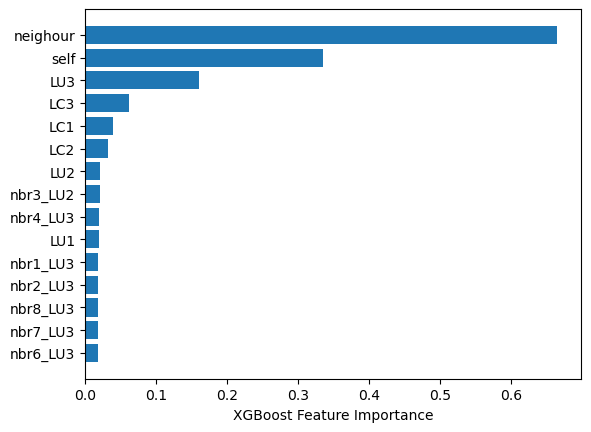

In [77]:
plt.barh(df_feat.index.values[::-1][-15:], df_feat.feature_importance.values[::-1][-15:])
# plt.xlabel("Random Forest Feature Importance")
plt.xlabel("XGBoost Feature Importance")

Text(0.5, 0, 'XGBoost Feature Importance')

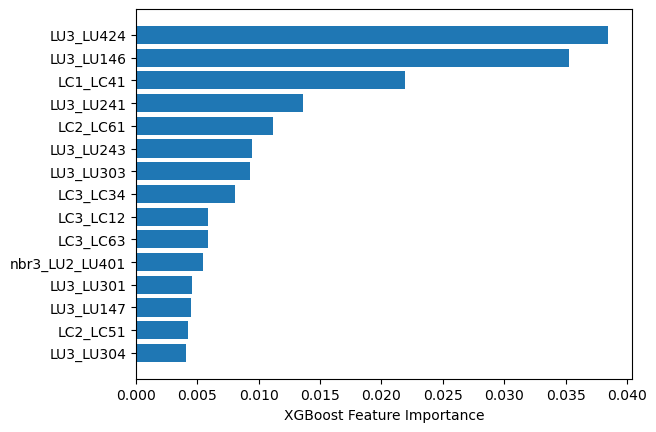

In [79]:
feature_imp.sort_values('feature_importance', inplace=True, ascending=False)
plt.barh(feature_imp.feature.values[::-1][-15:], feature_imp.feature_importance.values[::-1][-15:])
# plt.xlabel("Random Forest Feature Importance")
plt.xlabel("XGBoost Feature Importance")